# ⚛️ H₂ VQE — Noise Scans, ΔE Shifts & Fidelity Analysis

This notebook explores how **noise** affects the **Variational Quantum Eigensolver (VQE)**
for the hydrogen molecule **H₂**, using a clean two-part educational + production structure.

---

# **🧩 Part 1 — Manual Noisy VQE (Educational)**

In this section we:

- Build a **noisy PennyLane QNode** by hand  
- Use a simple **TwoQubit-RY-CNOT ansatz**  
- Inject explicit:
  - `DepolarizingChannel(p)`
  - `AmplitudeDamping(p)`  
- Run a minimal optimisation loop with **GradientDescent**

This section illustrates *how noise enters a quantum circuit directly*.

---

# **🟦 Part 2 — Package-Level Noise Sweeps (Production Workflow)**

Using your VQE engine (`vqe.core`) we:

- Compute a **noiseless reference state**  
- Sweep noise levels using:
  - `run_vqe_noise_sweep`
  - `run_vqe_multi_seed_noise`
- Obtain:
  - **Energy shift ΔE ← E_noisy − E_reference**
  - **Fidelity vs. reference**
  - **Mean ± std** across seeds
- Automatically generate and save:
  - ΔE vs noise  
  - Fidelity vs noise  
  - Convergence curves  

This section represents the **real scientific workflow**, fully cached and reproducible.

---

In [1]:
# Core scientific stack
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Package API
from vqe.core import (
    run_vqe,
    run_vqe_noise_sweep,
    run_vqe_multi_seed_noise,
)

from vqe_qpe_common.plotting import IMG_DIR

# Basic H₂ setup for the manual demo
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414],
])
basis = "sto-3g"

# Active space restriction for H₂ (2 electrons, 2 orbitals)
H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    basis=basis,
    active_electrons=2,
    active_orbitals=2,
)

num_wires = qubits
print(f"H₂ with basis={basis}: {num_wires} qubits")

H₂ with basis=sto-3g: 4 qubits


# 🧩 Part 1 — Manual Noisy VQE Demo  

This section demonstrates **explicit noise injection** inside a PennyLane QNode.

We:

- Build a **TwoQubit-RY-CNOT** ansatz  
- Add noise channels manually  
- Run a small VQE loop  

This is purely for *educational insight* — the package API handles all of this internally.

[demo] Step 01/30 — E = 1.305783 Ha
[demo] Step 02/30 — E = 1.305254 Ha
[demo] Step 03/30 — E = 1.304623 Ha
[demo] Step 04/30 — E = 1.303871 Ha
[demo] Step 05/30 — E = 1.302972 Ha
[demo] Step 06/30 — E = 1.301898 Ha
[demo] Step 07/30 — E = 1.300613 Ha
[demo] Step 08/30 — E = 1.299076 Ha
[demo] Step 09/30 — E = 1.297236 Ha
[demo] Step 10/30 — E = 1.295032 Ha
[demo] Step 11/30 — E = 1.292393 Ha
[demo] Step 12/30 — E = 1.289230 Ha
[demo] Step 13/30 — E = 1.285441 Ha
[demo] Step 14/30 — E = 1.280901 Ha
[demo] Step 15/30 — E = 1.275463 Ha
[demo] Step 16/30 — E = 1.268955 Ha
[demo] Step 17/30 — E = 1.261169 Ha
[demo] Step 18/30 — E = 1.251865 Ha
[demo] Step 19/30 — E = 1.240762 Ha
[demo] Step 20/30 — E = 1.227535 Ha
[demo] Step 21/30 — E = 1.211812 Ha
[demo] Step 22/30 — E = 1.193170 Ha
[demo] Step 23/30 — E = 1.171140 Ha
[demo] Step 24/30 — E = 1.145205 Ha
[demo] Step 25/30 — E = 1.114816 Ha
[demo] Step 26/30 — E = 1.079401 Ha
[demo] Step 27/30 — E = 1.038392 Ha
[demo] Step 28/30 — E = 0.99

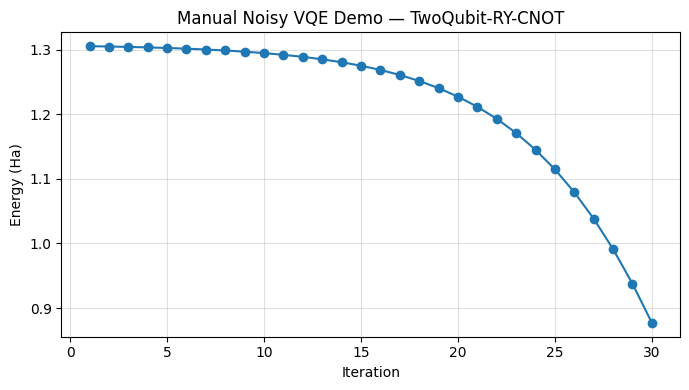

'/workspaces/Variational_Quantum_Eigensolver/images/H2_Manual_Noisy_VQE_Demo.png'

In [2]:
# Simple two-qubit ansatz: RY on qubit 0 → CNOT(0→1) → RY on qubit 1
def two_qubit_ry_cnot(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[1], wires=wires[1])

# Noise parameters for manual demo
p_dep_demo = 0.02
p_amp_demo = 0.04

dev_noisy = qml.device("default.mixed", wires=num_wires)

@qml.qnode(dev_noisy, diff_method="finite-diff")
def noisy_energy(params):
    # Apply ansatz
    two_qubit_ry_cnot(params, wires=[0, 1])

    # Inject noise per qubit
    for w in range(num_wires):
        qml.DepolarizingChannel(p_dep_demo, wires=w)
        qml.AmplitudeDamping(p_amp_demo, wires=w)

    return qml.expval(H)

# Manual VQE loop
opt = qml.GradientDescentOptimizer(stepsize=0.1)
params = 0.1 * np.random.randn(2, requires_grad=True)

energies_demo = []
n_steps_demo = 30

for step in range(n_steps_demo):
    params, e_prev = opt.step_and_cost(noisy_energy, params)
    e_val = float(noisy_energy(params))
    energies_demo.append(e_val)
    print(f"[demo] Step {step+1:02d}/{n_steps_demo} — E = {e_val:.6f} Ha")

plt.figure(figsize=(7, 4))
plt.plot(range(1, n_steps_demo + 1), energies_demo, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("Manual Noisy VQE Demo — TwoQubit-RY-CNOT")
plt.grid(True, alpha=0.4)
plt.tight_layout()

fname_demo = os.path.join(IMG_DIR, "H2_Manual_Noisy_VQE_Demo.png")
plt.savefig(fname_demo, dpi=300)
plt.show()

fname_demo

# 🟦 Part 2 — Noiseless Reference via Package API

Before scanning noise levels, we compute a **noiseless reference state** using:

```python
run_vqe(...)
```

This returns:

- Final energy  
- Convergence trace  
- Statevector (`final_state_real`, `final_state_imag`)  

This state is used for **fidelity** and **ΔE shifts**.

In [3]:
ref_result = run_vqe(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    n_steps=50,
    stepsize=0.2,
    noisy=False,
    plot=True,
    seed=0,
    force=False,
)

reference_energy = ref_result["energy"]
psi_real = np.array(ref_result["final_state_real"])
psi_imag = np.array(ref_result["final_state_imag"])
reference_state = psi_real + 1j * psi_imag

reference_energy


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__821ace67521d.json


-1.111054843431207

# 🔬 Part 3 — Single-Seed Noise Sweeps  

Using:

```python
run_vqe_noise_sweep(...)
```

we sweep noise levels and compute:

- Energy shift ΔE  
- Fidelity vs reference  

The function automatically:

- Runs VQE with each noise level  
- Computes reference internally (unless provided)  
- Generates a 2-panel figure  
- Saves plots to `images/`  


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__e08edbda183a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__91d11ac31b7c.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__52e4591584ec.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__97e168fed872.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__c30c1c2d5c8a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__cb4f3e891108.json
📁 Saved → /workspaces/Variational_Quantum_Eigensolver/images/vqe/VQE_Noise_Stat

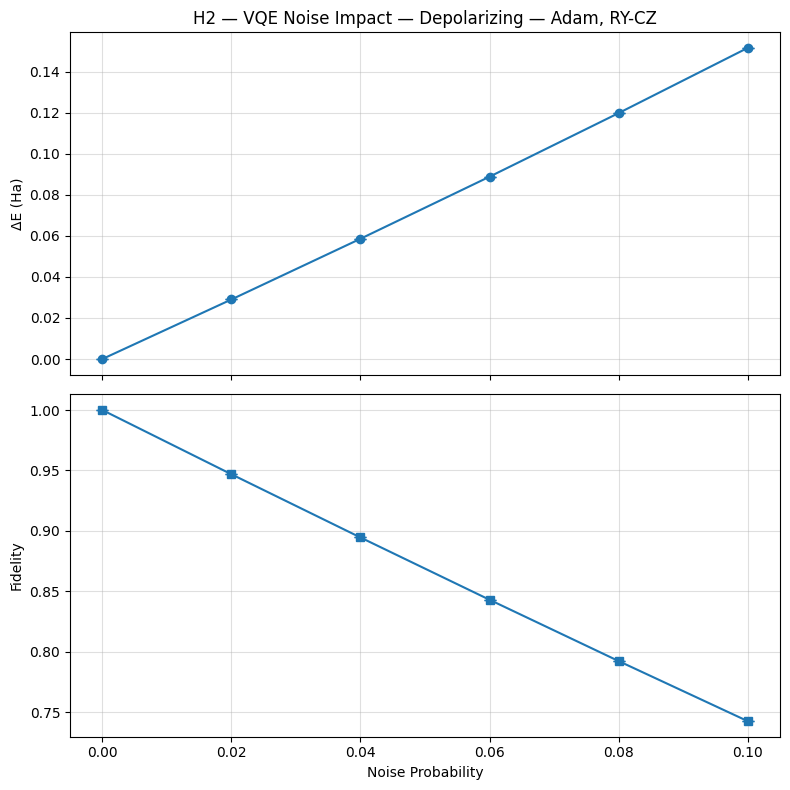


✅ Noise sweep complete for H2 (RY-CZ, Adam)


In [4]:
# Sweep depolarizing noise
run_vqe_noise_sweep(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),
    amplitude_damping_probs=np.zeros(6),
    force=False,
    mapping="jordan_wigner",
)


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__e08edbda183a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__d1ff375817fd.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__32a1236cd4c1.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__d9cbfbf98b0b.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__7cb746c1e75b.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__8a1a43c96b09.json
📁 Saved → /workspaces/Variational_Quantum_Eigensolver/images/vqe/VQE_Noise_Stat

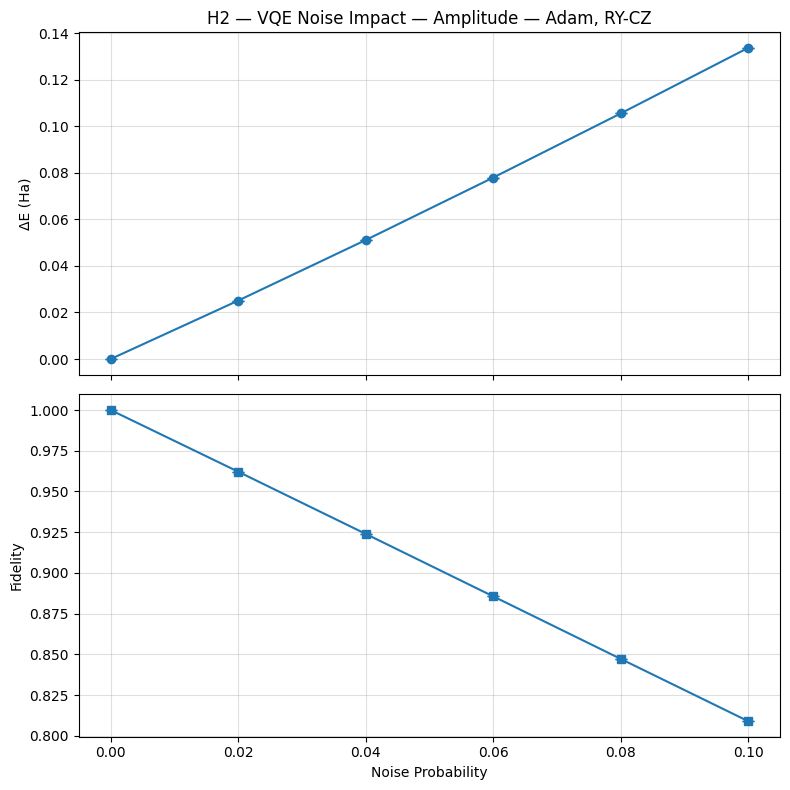


✅ Noise sweep complete for H2 (RY-CZ, Adam)


In [5]:
# Sweep amplitude damping noise
run_vqe_noise_sweep(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    depolarizing_probs=np.zeros(6),
    amplitude_damping_probs=np.arange(0.0, 0.11, 0.02),
    force=False,
    mapping="jordan_wigner",
)

# 📈 Part 4 — Multi-Seed Noise Statistics  

To understand **run-to-run variability**, we call:

```python
run_vqe_multi_seed_noise(...)
```

For each noise level:

- VQE runs across multiple seeds  
- ΔE and fidelity are aggregated  
- Mean ± std is computed  

The resulting figures show:

- ΔE vs noise (error bars)  
- Fidelity vs noise (error bars)  

All plots are saved automatically.


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s1__f4025b548242.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s2__5c18ed9e16b8.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s3__532e5734d599.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s4__dfdc5b90a02d.json
Reference mean energy = -1.050301 Ha

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__e08edbda183a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s1__99f

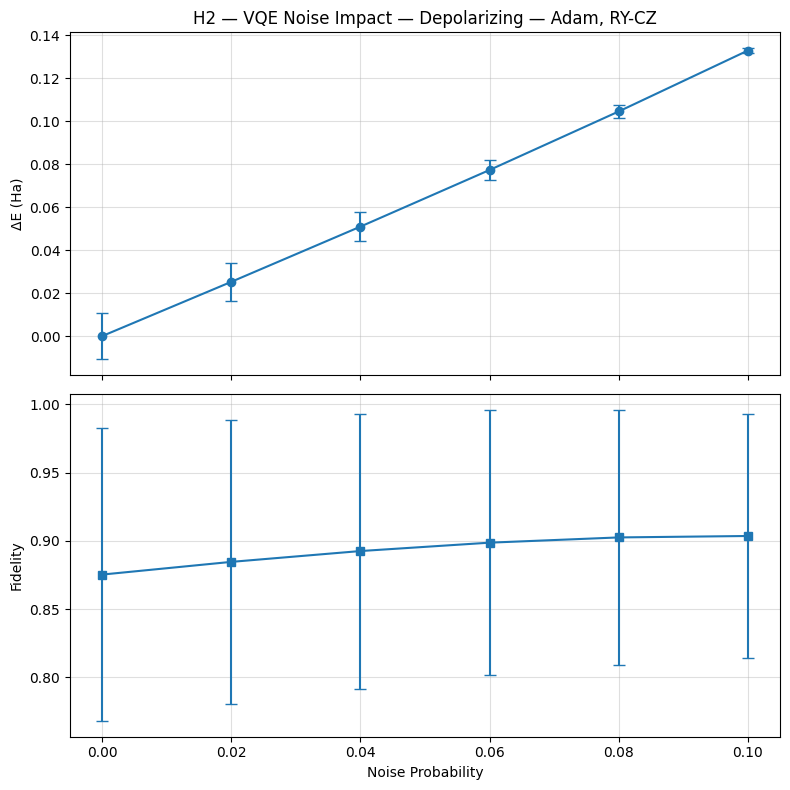


✅ Multi-seed noise study complete for H2


In [6]:
# Multi-seed depolarizing noise
run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    stepsize=0.2,
    seeds=np.arange(0, 5),
    noise_type="depolarizing",
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),
    force=False,
    mapping="jordan_wigner",
)


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__a8709a2afbe0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s1__f4025b548242.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s2__5c18ed9e16b8.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s3__532e5734d599.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s4__dfdc5b90a02d.json
Reference mean energy = -1.050301 Ha

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__e08edbda183a.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s1__99f

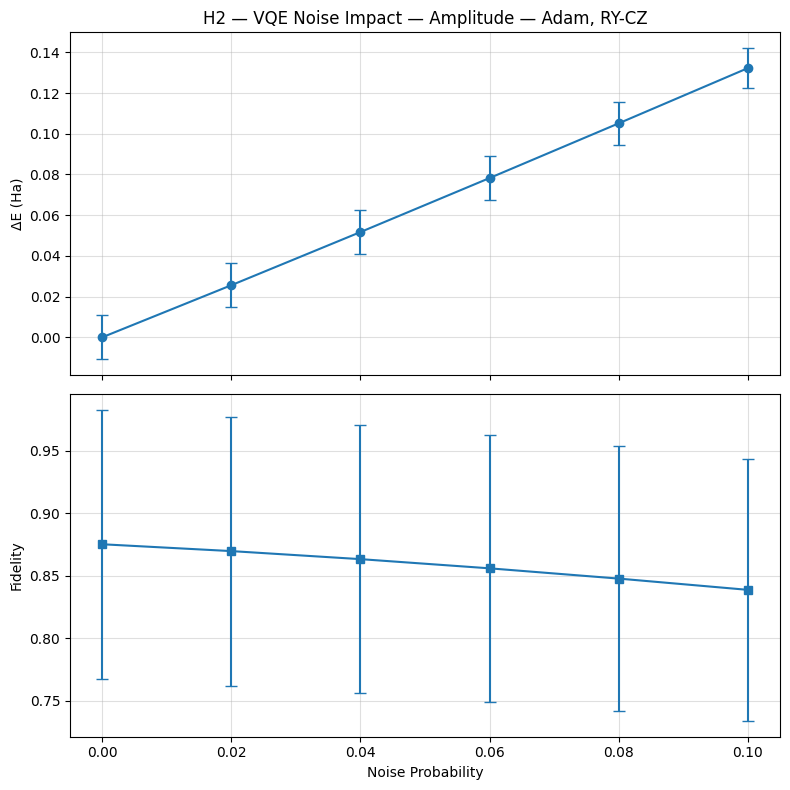


✅ Multi-seed noise study complete for H2


In [7]:
# Multi-seed amplitude-damping noise
run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    stepsize=0.2,
    seeds=np.arange(0, 5),
    noise_type="amplitude",
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),   # reused internally
    force=False,
    mapping="jordan_wigner",
)

# 🧾 Summary

In this notebook you:

### ✔ Built a manual noisy VQE to see how noise is injected  
### ✔ Computed a noiseless reference state with `run_vqe`  
### ✔ Performed single-seed noise sweeps (ΔE vs noise, fidelity vs noise)  
### ✔ Performed multi-seed noise statistics for robust analysis  

This completes a **full educational + production-ready** exploration of VQE
under noise for H₂.